In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
from torch.utils.data import DataLoader, Dataset
import pickle
import seaborn as sns
sns.set_style("darkgrid")

In [79]:
# NOTE TO MARKERS:
# download the data from https://www.kaggle.com/datasets/nathanlauga/nba-games
# adjust PATH_DIR and the name of the downloaded folder to whatever your set-up is
PATH_DIR = "/content/gdrive/MyDrive/Colab Notebooks/CSC413 Project/"
# right now we are loading the x.pkl and y.pkl files that will be used below
# if you don't want to download them from our github and want to run the code from scratch, change load to false
load = True
games = pd.read_csv(PATH_DIR + '/NathanDataSet/games.csv', index_col="GAME_ID")
rankings = pd.read_csv(PATH_DIR + '/NathanDataSet/ranking.csv')
box_scores = pd.read_csv(PATH_DIR + '/NathanDataSet/games_details.csv')

<ipython-input-79-dd565e78c86e>:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  box_scores = pd.read_csv(PATH_DIR + '/NathanDataSet/games_details.csv')


In [5]:
earliest_game = games['GAME_DATE_EST'].min()
print(earliest_game)
earliest_ranking = rankings['STANDINGSDATE'].min()
print(earliest_ranking)

2003-10-05
2003-10-01


In [6]:
# remove games and rankings from prior to the 2014-15 season
games = games.loc[pd.to_datetime(games['GAME_DATE_EST']) > pd.to_datetime('2014-09-01')]
rankings = rankings.loc[pd.to_datetime(rankings['STANDINGSDATE']) > pd.to_datetime('2014-09-01')]
print(games['GAME_DATE_EST'].min())
print(rankings['STANDINGSDATE'].min())

2014-10-04
2014-09-02


In [7]:
# Let's start some Data exploration
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11420 entries, 22200477 to 11400001
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     11420 non-null  object 
 1   GAME_STATUS_TEXT  11420 non-null  object 
 2   HOME_TEAM_ID      11420 non-null  int64  
 3   VISITOR_TEAM_ID   11420 non-null  int64  
 4   SEASON            11420 non-null  int64  
 5   TEAM_ID_home      11420 non-null  int64  
 6   PTS_home          11420 non-null  float64
 7   FG_PCT_home       11420 non-null  float64
 8   FT_PCT_home       11420 non-null  float64
 9   FG3_PCT_home      11420 non-null  float64
 10  AST_home          11420 non-null  float64
 11  REB_home          11420 non-null  float64
 12  TEAM_ID_away      11420 non-null  int64  
 13  PTS_away          11420 non-null  float64
 14  FG_PCT_away       11420 non-null  float64
 15  FT_PCT_away       11420 non-null  float64
 16  FG3_PCT_away      11420 non-nu

In [8]:
games.head()

,GAME_DATE_EST,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
GAME_ID,,,,,,,,,,,,,,,,,,,,
22200477,2022-12-22,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,0.382,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
22200478,2022-12-22,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,0.457,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
22200466,2022-12-21,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,0.313,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
22200467,2022-12-21,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,0.297,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
22200468,2022-12-21,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,0.378,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


<Axes: >

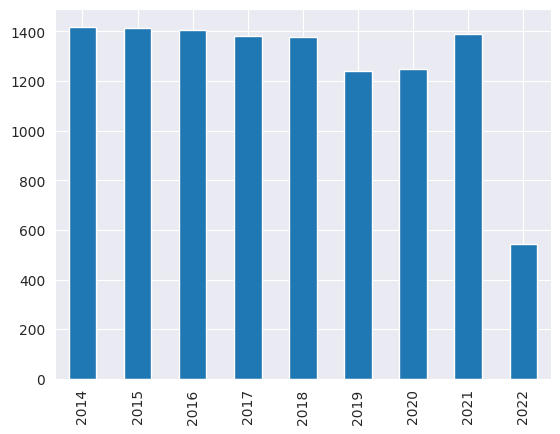

In [9]:
games['SEASON'].astype('category').value_counts().sort_index().plot(kind='bar')

In [10]:
rankings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91049 entries, 0 to 210326
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TEAM_ID        91049 non-null  int64  
 1   LEAGUE_ID      91049 non-null  int64  
 2   SEASON_ID      91049 non-null  int64  
 3   STANDINGSDATE  91049 non-null  object 
 4   CONFERENCE     91049 non-null  object 
 5   TEAM           91049 non-null  object 
 6   G              91049 non-null  int64  
 7   W              91049 non-null  int64  
 8   L              91049 non-null  int64  
 9   W_PCT          91049 non-null  float64
 10  HOME_RECORD    91049 non-null  object 
 11  ROAD_RECORD    91049 non-null  object 
 12  RETURNTOPLAY   3990 non-null   float64
dtypes: float64(2), int64(6), object(5)
memory usage: 9.7+ MB


In [11]:
rankings.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612743,0,22022,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8,NaN
1,1610612763,0,22022,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9,NaN
2,1610612740,0,22022,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8,NaN
3,1610612756,0,22022,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9,NaN
4,1610612746,0,22022,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7,NaN


In [12]:
hometeams_won = games.HOME_TEAM_WINS.value_counts()
hometeams_won

1    6522
0    4898
Name: HOME_TEAM_WINS, dtype: int64

<Axes: >

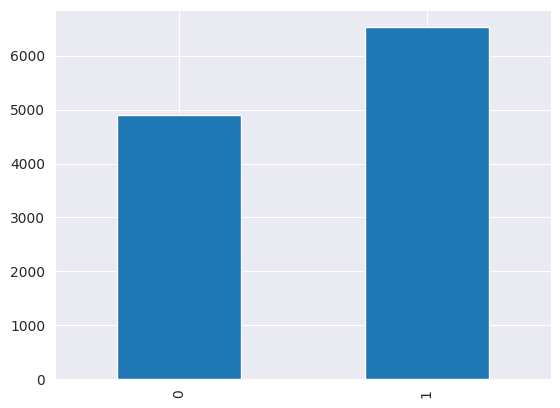

In [13]:
hometeams_won.sort_values(ascending=True).plot(kind='bar')

In [14]:
box_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668628 entries, 0 to 668627
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            668628 non-null  int64  
 1   TEAM_ID            668628 non-null  int64  
 2   TEAM_ABBREVIATION  668628 non-null  object 
 3   TEAM_CITY          668628 non-null  object 
 4   PLAYER_ID          668628 non-null  int64  
 5   PLAYER_NAME        668628 non-null  object 
 6   NICKNAME           53037 non-null   object 
 7   START_POSITION     255765 non-null  object 
 8   COMMENT            109689 non-null  object 
 9   MIN                558938 non-null  object 
 10  FGM                558938 non-null  float64
 11  FGA                558938 non-null  float64
 12  FG_PCT             558938 non-null  float64
 13  FG3M               558938 non-null  float64
 14  FG3A               558938 non-null  float64
 15  FG3_PCT            558938 non-null  float64
 16  FT

In [15]:
box_scores.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [16]:
top_10 = box_scores.sort_values(by=['PTS'], ascending=False).head(10)
top_10

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
226714,20500591,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,41:56,...,2.0,4.0,6.0,2.0,3.0,1.0,3.0,1.0,81.0,25.0
490689,21601076,1610612756,PHX,Phoenix,1626164,Devin Booker,NaN,G,NaN,44:58,...,2.0,6.0,8.0,6.0,3.0,1.0,5.0,3.0,70.0,-6.0
182958,20600977,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,49:58,...,1.0,6.0,7.0,3.0,3.0,0.0,2.0,3.0,65.0,4.0
284306,20300927,1610612753,ORL,Orlando,1503,Tracy McGrady,NaN,G,NaN,45:50,...,3.0,7.0,10.0,5.0,1.0,0.0,6.0,1.0,62.0,10.0
613353,21300640,1610612752,NYK,New York,2546,Carmelo Anthony,NaN,F,NaN,38:39,...,1.0,12.0,13.0,0.0,0.0,0.0,0.0,1.0,62.0,34.0
232268,20500359,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,32:53,...,3.0,5.0,8.0,0.0,3.0,0.0,2.0,3.0,62.0,35.0
82403,22000092,1610612744,GSW,Golden State,201939,Stephen Curry,NaN,G,NaN,36:26,...,1.0,4.0,5.0,4.0,0.0,0.0,5.0,0.0,62.0,20.0
98400,21900652,1610612757,POR,Portland,203081,Damian Lillard,NaN,G,NaN,45:08,...,0.0,10.0,10.0,7.0,1.0,0.0,2.0,1.0,61.0,13.0
121397,20800709,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,36:48,...,0.0,0.0,0.0,3.0,0.0,1.0,2.0,1.0,61.0,19.0
428734,21800710,1610612745,HOU,Houston,201935,James Harden,NaN,G,NaN,40:00,...,6.0,9.0,15.0,4.0,5.0,0.0,5.0,3.0,61.0,19.0


In [17]:
players = box_scores.PLAYER_NAME.unique()
print(len(players))
print(len(box_scores))

2664
668628


In [19]:
# calculate the highest points, rebounds and assists recorded for scaling down between 0 to 1 as a percentage
max_points = max(games['PTS_home'].max(), games['PTS_away'].max())
max_assists = max(games['AST_home'].max(), games['AST_away'].max())
max_reb = max(games['REB_home'].max(), games['REB_away'].max())
print('Max points: {}, Max assists: {}, Max reb: {}'.format(max_points, max_assists, max_reb))

Max points: 168.0, Max assists: 50.0, Max reb: 81.0


In [20]:
# returns data from the most recent x (by default 10) games played by the given team on the given date
def get_last_x_games(tid, date, x = 10):
  before = pd.to_datetime(date)
  g = games.loc[(games["HOME_TEAM_ID"]==tid) | (games["VISITOR_TEAM_ID"]==tid)].sort_values(by=['GAME_DATE_EST'])
  # rescale points, rebounds and assists
  g.loc[:, 'PTS_home'],  g.loc[:, 'PTS_away'] = g['PTS_home']/max_points, g['PTS_away']/max_points
  g.loc[:, 'AST_home'], g.loc[:, 'AST_away'] = g['AST_home']/max_assists, g['AST_away']/max_assists
  g.loc[:, 'REB_home'], g.loc[:, 'REB_away'] = g['REB_home']/max_reb, g['REB_away']/max_reb
  # drop N/A data
  g = g.dropna()
  # filter by date and get the most recent x games
  g = g[pd.to_datetime(g['GAME_DATE_EST']) < before].tail(x)
  # drop non numerical and irrelevant data
  g.drop(columns=['GAME_DATE_EST', 'GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away'], inplace=True)
  return g

In [21]:
print(get_last_x_games(1610612759, '2022-12-13'))

          HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  PTS_home  FG_PCT_home  \
GAME_ID                                                                  
22200247    1610612747       1610612759    2022  0.732143        0.529   
22200269    1610612759       1610612740    2022  0.654762        0.482   
22200282    1610612759       1610612747    2022  0.559524        0.380   
22200288    1610612759       1610612747    2022  0.821429        0.505   
22200319    1610612760       1610612759    2022  0.708333        0.511   
22200333    1610612759       1610612740    2022  0.589286        0.388   
22200345    1610612759       1610612756    2022  0.565476        0.437   
22200375    1610612759       1610612745    2022  0.702381        0.554   
22200387    1610612748       1610612759    2022  0.660714        0.481   
22200406    1610612759       1610612739    2022  0.666667        0.474   

          FT_PCT_home  FG3_PCT_home  AST_home  REB_home  PTS_away  \
GAME_ID                                   

In [22]:
# return the most recent x (by default 3) games played between the two times on a given date
def get_last_x_matchups(hid, vid, date, x = 3):
  before = pd.to_datetime(date)
  g1 = games.loc[(games["HOME_TEAM_ID"]==hid) & (games["VISITOR_TEAM_ID"]==vid)]
  g2 = games.loc[(games["HOME_TEAM_ID"]==vid) & (games["VISITOR_TEAM_ID"]==hid)]
  # swap the home and away values for games played between the two teams, but when home was away and vice versa
  g2.rename(columns={'PTS_away': 'PTS_home', 'FG_PCT_away': 'FG_PCT_home',
      'FT_PCT_away': 'FT_PCT_home', 'FG3_PCT_away': 'FG3_PCT_home', 'AST_away': 'AST_home', 'REB_away': 'REB_home',
      'PTS_home': 'PTS_away', 'FG_PCT_home': 'FG_PCT_away',
      'FT_PCT_home': 'FT_PCT_away', 'FG3_PCT_home': 'FG3_PCT_away', 'AST_home': 'AST_away', 'REB_home': 'REB_away'
  }, inplace=True)
  g2['HOME_TEAM_WINS'] = 1 - g2['HOME_TEAM_WINS']
  g = pd.concat((g1, g2)).sort_values(by=['GAME_DATE_EST'])
  # drop N/A data
  g = g.dropna()
  # rescale stats
  g['PTS_home'],  g['PTS_away'] = g['PTS_home']/max_points, g['PTS_away']/max_points
  g['AST_home'], g['AST_away'] = g['AST_home']/max_assists, g['AST_away']/max_assists
  g['REB_home'], g['REB_away'] = g['REB_home']/max_reb, g['REB_away']/max_reb
  # filter by date and get the most recent x games
  g = g[pd.to_datetime(g['GAME_DATE_EST']) < before].tail(x)
  # return null if there isnt enough data
  if len(g)<x:
    return None
  # drop non numerical and irrelevant data
  g.drop(columns=['GAME_DATE_EST', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID','TEAM_ID_home', 'TEAM_ID_away'], inplace=True)
  return g

In [23]:
print(get_last_x_matchups(1610612759,1610612737, '2022-12-13'))

          SEASON  PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  \
GAME_ID                                                                        
22000735    2020  0.767857        0.445        0.750         0.325      0.50   
22100277    2021  0.630952        0.430        0.800         0.364      0.54   
22100841    2021  0.809524        0.556        0.857         0.563      0.74   

          REB_home  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  \
GAME_ID                                                                
22000735  0.567901  0.797619        0.500        0.808         0.542   
22100277  0.543210  0.738095        0.511        0.917         0.462   
22100841  0.506173  0.720238        0.456        0.867         0.326   

          AST_away  REB_away  HOME_TEAM_WINS  
GAME_ID                                       
22000735      0.56  0.703704               0  
22100277      0.52  0.543210               0  
22100841      0.56  0.604938               1  


<ipython-input-22-8fc18c34f46b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2.rename(columns={'PTS_away': 'PTS_home', 'FG_PCT_away': 'FG_PCT_home',
<ipython-input-22-8fc18c34f46b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['HOME_TEAM_WINS'] = 1 - g2['HOME_TEAM_WINS']


In [24]:
# get the team's seasonal performance on a given date
def get_team_ranking(tid, date):
  before = pd.to_datetime(date)
  tr = rankings.loc[rankings['TEAM_ID'] == tid]
  tr['STANDINGSDATE'] = pd.to_datetime(tr['STANDINGSDATE'])
  # filter by date to see the teams record on a given date
  tr = tr.loc[tr['STANDINGSDATE']== before][:1]
  # calculate the home and away win percentages
  # they are in the format "wins-losses", so we need to calculate wins/(wins+losses) by splitting on "-"
  tr['HOME_RECORD'] = tr['HOME_RECORD'].apply(lambda x: float(x.split('-')[0])/(max(1, float(x.split('-')[0]) + float(x.split('-')[1]))))
  tr['ROAD_RECORD'] = tr['ROAD_RECORD'].apply(lambda x: float(x.split('-')[0])/(max(1, float(x.split('-')[0]) + float(x.split('-')[1]))))
  # drop non numerical and irrelevant data
  tr.drop(columns = ['SEASON_ID', 'TEAM_ID', 'LEAGUE_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'RETURNTOPLAY'], inplace=True)
  # drop N/A data
  tr = tr.dropna()
  return tr

In [25]:
print(get_team_ranking(1610612759, '2022-12-13'))

      G  W   L  W_PCT  HOME_RECORD  ROAD_RECORD
149  27  9  18  0.333     0.333333     0.333333


<ipython-input-24-3e197fa5e9b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr['STANDINGSDATE'] = pd.to_datetime(tr['STANDINGSDATE'])


In [26]:
# create vectors for every game played containing sequences for the home and away team's recent game history and matchups, as well as their seasonal performances
# returns the game data and the winner label
def make_game_data():
  g = games.sort_values(by=['GAME_DATE_EST'])
  Y, T = [], []
  #iterate over all games
  for (_, game) in g.iterrows():
    home_team = game['HOME_TEAM_ID']
    away_team = game['VISITOR_TEAM_ID']
    date = game['GAME_DATE_EST']
    # calculate all the matchups, game history and ranking data for both teams in a given game
    matchup_history = get_last_x_matchups(home_team, away_team, date)
    if matchup_history is None:
      continue
    home_team_history, away_team_history = get_last_x_games(home_team, date), get_last_x_games(away_team, date)
    home_team_rank, away_team_rank = get_team_ranking(home_team, date), get_team_ranking(away_team, date)
    # Y contains the game data
    Y.append((home_team_history.to_numpy(), away_team_history.to_numpy(), matchup_history.to_numpy(), home_team_rank.to_numpy(), away_team_rank.to_numpy()))
    # T contains the winner of the game indicated by the binary value of if home won or not
    T.append(game['HOME_TEAM_WINS'])
  Y = np.array(Y)
  T = np.array(T)
  return Y, T

In [81]:
# NOTE FOR MARKERS:
# DOWNLOAD THE PROVIDED X.PKL AND Y.PKL FILES AND PLACE THEM IN YOUR PATH_DIR
# OR CHANGE LOAD AT THE TOP OF THE FILE TO FALSE (TAKES ABOUT 10-15 MINUTES TO RUN)
if load:
  # if load is true, we've already ran and saved make_game_data() to files and will load our all_X and all_Y values
  with open(os.path.join(PATH_DIR, 'x.pkl'), 'rb') as f:
      all_X = pickle.load(f)
  with open(os.path.join(PATH_DIR, 'y.pkl'), 'rb') as f:
      all_Y = pickle.load(f)
else:
  # else, we need to run to initialize our data and save it in files for future use (it takes about 20-30 minutes to run it)
  all_X, all_Y = make_game_data()
  with open(os.path.join(PATH_DIR, 'x.pkl'), 'wb') as f:
    pickle.dump(all_X, f, protocol=pickle.HIGHEST_PROTOCOL)

  with open(os.path.join(PATH_DIR, 'y.pkl'), 'wb') as f:
    pickle.dump(all_Y, f, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
# object to conveniently store and retrieve our game data
class gamesData(Dataset):
  def __init__(self, gameStats, labels):
    self.gameStats = gameStats
    self.labels = labels

  def __len__(self):
    return len(self.gameStats)

  def __getitem__(self, x):
    return torch.Tensor(self.gameStats[x][0]), torch.Tensor(self.gameStats[x][1]), torch.Tensor(self.gameStats[x][2]), self.gameStats[x][3], self.gameStats[x][4], self.labels[x]

In [31]:
BATCH_SIZE = 64
# a 60/20/20 split for training, validation and testing
train_X, val_X, test_X = np.split(all_X, [int(len(all_X)*0.6),int(len(all_X)*0.8)])
train_Y, val_Y, test_Y = np.split(all_Y, [int(len(all_Y)*0.6), int(len(all_Y)*0.8)])
train_data = gamesData(train_X, train_Y)
valid_data = gamesData(val_X, val_Y)
test_data = gamesData(test_X, test_Y)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle = True)

In [76]:
for home_history, away_history, matchup_history, home_ranking, away_ranking, game_winner in train_loader:
  print(f'Home History Shape: {home_history.shape}')
  print(f'Away History Shape: {away_history.shape}')
  print(f'Matchup History Shape: {matchup_history.shape}')
  print(f'Home Ranking Shape: {home_ranking.shape}')
  print(f'Away Ranking Shape: {away_ranking.shape}')
  print(f'Game Winner Shape: {game_winner}')
  break
TEAM_DIM = home_history.shape[2]
MATCHUP_DIM = matchup_history.shape[2]
RANK_DIM = home_ranking.shape[2]

# Our Prediction model
class GamePredictionNetwork(nn.Module):
    def __init__(self, 
                 team_dim = TEAM_DIM,
                 matchup_dim = MATCHUP_DIM,
                 rank_dim = RANK_DIM,
                 hidden_dim = 64):
        
      super().__init__()
      
      # Our History data will be put through an LSTM for each sequence (home, away, matchup)
      # Input size: team_dim
      # Output size: hidden_dim
      self.home_lstm = nn.LSTM(team_dim, hidden_dim, batch_first=True)
      self.away_lstm = nn.LSTM(team_dim, hidden_dim, batch_first=True)
      self.matchup_lstm = nn.LSTM(matchup_dim, hidden_dim, batch_first=True)
      
      # These LSTM's are combined in a 2 linear layers to go from size 3*hidden_dim to hidden_dim
      # there is ReLU activation after each, and a dropout layer of p=0.1 at the end
      self.lstm_linear = nn.Sequential(
          nn.Linear(hidden_dim*3, hidden_dim*2),
          nn.ReLU(),
          nn.Linear(hidden_dim*2, hidden_dim),
          nn.ReLU(),
          nn.Dropout(0.1),
      )
      
      # Our ranking data is run through a series of linear layers with ReLU activation and dropout of p=0.1 at the end
      self.home_rank = nn.Sequential(
          nn.Linear(rank_dim, rank_dim*8),
          nn.ReLU(),
          nn.Linear(rank_dim*8, rank_dim*16),
          nn.ReLU(),
          nn.Linear(rank_dim*16, rank_dim*8),
          nn.ReLU(),
          nn.Linear(rank_dim*8, rank_dim),
          nn.ReLU(),
          nn.Dropout(0.1),
      )

      self.away_rank = nn.Sequential(
          nn.Linear(rank_dim, rank_dim*8),
          nn.ReLU(),
          nn.Linear(rank_dim*8, rank_dim*16),
          nn.ReLU(),
          nn.Linear(rank_dim*16, rank_dim*8),
          nn.ReLU(),
          nn.Linear(rank_dim*8, rank_dim),
          nn.ReLU(),
          nn.Dropout(0.1),
      )
      
      # we run our combined data through one last linear layer 
      self.fc = nn.Linear(rank_dim*2+hidden_dim, 1)

      # sigmoid activation for the prediction
      self.sigmoid = nn.Sigmoid()

    def forward(self, home_history, away_history, matchup_history, home_ranking, away_ranking):
      # here we forward pass our LSTMS and obtain the final hidden states
      (_, (h_h, _)), (_, (a_h, _)), (_, (m_h, _)) = self.home_lstm(home_history), self.away_lstm(away_history), self.matchup_lstm(matchup_history)
      # combine our lstms together in a series of linear layers
      lstm_combined = self.lstm_linear(torch.cat([h_h[-1].unsqueeze(1), a_h[-1].unsqueeze(1), m_h[-1].unsqueeze(1)], dim=2))
      # run our ranking through a series of linear layers each and concatenate the end results together
      rank_combined = torch.cat((self.away_rank(home_ranking), self.away_rank(away_ranking)), dim=2)
      # combine all our data
      combined = torch.cat([lstm_combined, rank_combined], dim=2)
      # run it through the last linear layer and use sigmoid activation for the final prediction
      pred = self.sigmoid(self.fc(combined)).squeeze(dim=1).squeeze(dim=1)
      return pred

Home History Shape: torch.Size([64, 10, 16])
Away History Shape: torch.Size([64, 10, 16])
Matchup History Shape: torch.Size([64, 3, 14])
Home Ranking Shape: torch.Size([64, 1, 6])
Away Ranking Shape: torch.Size([64, 1, 6])
Game Winner Shape: tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1])


In [39]:
# here is our model set up
LEARNING_RATE = 0.0005
model = GamePredictionNetwork()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

In [35]:
def get_accuracy(model, loader, isTrain):
  epoch_loss, correct, total = 0, 0, 0
  # change model mode according to data type
  model.train() if isTrain else model.eval()
  for i, data in enumerate(loader):
    # load data
    home_history, away_history, matchup_history, home_ranking, away_ranking, labels = data

    # forward and backward passes
    optimizer.zero_grad()
    predictions = model(home_history.float(), away_history.float(), matchup_history.float(), home_ranking.float(), away_ranking.float())
    loss = criterion(predictions, labels.float())
    loss.backward()
    optimizer.step()

    # calculate loss and correctness
    epoch_loss += loss.item()
    correct += (predictions.round() == labels.float()).sum().item()
    total += predictions.size(0)

  return epoch_loss/total, correct/total*100

Epoch 1:
Train loss: 0.010079599031802555, Train acc: 61.805898830120285%
Val loss: 0.009819003537451932, Val acc: 65.64508156203658%
Epoch 2:
Train loss: 0.009422345105653776, Train acc: 68.56154226396441%
Val loss: 0.00965654658493404, Val acc: 68.70983687592684%
Epoch 3:
Train loss: 0.00910981485862908, Train acc: 71.4615257867853%
Val loss: 0.009408392605072074, Val acc: 69.40187839841819%
Epoch 4:
Train loss: 0.008807081713828092, Train acc: 72.12061295106278%
Val loss: 0.00922515220825942, Val acc: 69.35244686109738%
Epoch 5:
Train loss: 0.008586094699202152, Train acc: 71.82402372713791%
Val loss: 0.009134939119949002, Val acc: 69.00642609985171%
Epoch 6:
Train loss: 0.008537412833923915, Train acc: 72.1700444883836%
Val loss: 0.009125368051816494, Val acc: 69.74789915966386%
Epoch 7:
Train loss: 0.0085610002991316, Train acc: 72.07118141374197%
Val loss: 0.009121820234863463, Val acc: 69.50074147305982%
Epoch 8:
Train loss: 0.008434747810869756, Train acc: 72.25243038391828%
Va

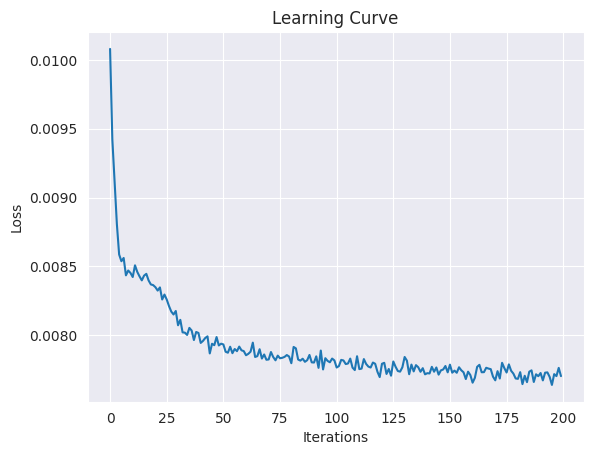

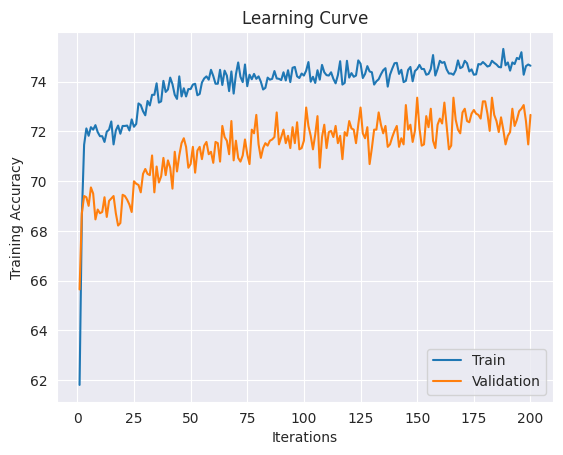

Final Training Accuracy: 74.64162135442413
Final Validation Accuracy: 72.66435986159169
Best Training Accuracy: 75.31718569780853 in Epoch: 188
Best Validation Accuracy: 73.35640138408304 in Epoch: 150


In [40]:
num_epochs = 200
iters, epochs, losses, t_acc, v_acc = [], [], [], [],[]
n = 0
best_training_epoch, best_training_accuracy, best_validation_epoch, best_validation_accuracy=0,0,0,0

# train the model
for epoch in range(num_epochs):
  train_loss, train_acc = get_accuracy(model, train_loader, True)
  val_loss, val_acc = get_accuracy(model, valid_loader, False)
  print('Epoch {}:'.format(epoch+1))
  print('Train loss: {}, Train acc: {}%'.format(train_loss, train_acc))
  print('Val loss: {}, Val acc: {}%'.format(val_loss, val_acc))
  iters.append(n)
  n+=1
  t_acc.append(train_acc)
  v_acc.append(val_acc)
  losses.append(train_loss)
  epochs.append(epoch+1)
  # update best accuracies and save best validation weights
  if train_acc > best_training_accuracy:
    best_training_accuracy = train_acc
    best_training_epoch = epoch+1
  if val_acc > best_validation_accuracy:
    best_validation_accuracy = val_acc
    best_validation_epoch = epoch+1
    torch.save(model.state_dict(), "best_validation_weights")

plt.title("Learning Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

plt.title("Learning Curve")
plt.plot(epochs, t_acc, label="Train")
plt.plot(epochs, v_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(t_acc[-1]))
print("Final Validation Accuracy: {}".format(v_acc[-1]))
print("Best Training Accuracy: {} in Epoch: {}".format(best_training_accuracy, best_training_epoch))
print("Best Validation Accuracy: {} in Epoch: {}".format(best_validation_accuracy, best_validation_epoch))

In [77]:
bestmodel = GamePredictionNetwork()
bestmodel.load_state_dict(torch.load("best_validation_weights"))
test_loss, test_acc = get_accuracy(bestmodel, test_loader, False)
print("Final Test Accuracy: {}".format(test_acc))
print("Final Test Loss: {}".format(test_loss))

Final Test Accuracy: 74.0484429065744
Final Test Loss: 0.008057163027448933


In [62]:
# find correctly and incorrectly classified data examples
correct, incorrect = 0, 0
correctdata, incorrectdata = None, None
loader = torch.utils.data.DataLoader(test_data, batch_size=1)
for i, data in enumerate(loader):
  home_history, away_history, matchup_history, home_ranking, away_ranking, label = data
  predictions = model(home_history.float(), away_history.float(), matchup_history.float(), home_ranking.float(), away_ranking.float())
  if (predictions.round().item()==label.item()) and correct < 1:
    correct = 1
    correctdata = data
  if (predictions.round().item()!=label.item()) and incorrect < 1:
    incorrect = 1
    incorrectdata = data
  if correct == 1 and incorrect == 1:
    break
print("Correctly predicted example:")
print(correctdata)
print("Incorrectly predicted example:")
print(incorrectdata)

Correctly predicted example:
[tensor([[[1.6106e+09, 1.6106e+09, 2.0200e+03, 6.2500e-01, 4.8300e-01,
          8.2400e-01, 3.3300e-01, 4.8000e-01, 2.9630e-01, 9.1667e-01,
          6.4000e-01, 9.5200e-01, 5.8500e-01, 7.2000e-01, 5.8025e-01,
          0.0000e+00],
         [1.6106e+09, 1.6106e+09, 2.0200e+03, 6.3095e-01, 5.0600e-01,
          7.1400e-01, 2.5000e-01, 4.8000e-01, 5.3086e-01, 6.5476e-01,
          4.5300e-01, 9.0900e-01, 3.6400e-01, 5.8000e-01, 4.5679e-01,
          0.0000e+00],
         [1.6106e+09, 1.6106e+09, 2.0200e+03, 5.8929e-01, 4.2000e-01,
          8.0600e-01, 1.7100e-01, 3.2000e-01, 4.9383e-01, 6.6071e-01,
          5.5600e-01, 6.2500e-01, 3.9300e-01, 5.4000e-01, 4.6914e-01,
          0.0000e+00],
         [1.6106e+09, 1.6106e+09, 2.0200e+03, 5.8929e-01, 3.5700e-01,
          7.2000e-01, 3.0600e-01, 4.2000e-01, 7.0370e-01, 6.1310e-01,
          4.1100e-01, 8.1300e-01, 2.7900e-01, 5.0000e-01, 6.0494e-01,
          0.0000e+00],
         [1.6106e+09, 1.6106e+09, 2.02